# Group 6 Project - Predicting Life Expectancy

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import graphviz
import tensorflow as tf

from google.colab import drive
from google.colab import files

from IPython.display import Image

from matplotlib.colors import Normalize

from scipy.stats import randint

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV, ElasticNet
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold, RandomizedSearchCV, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import export_graphviz, DecisionTreeRegressor, plot_tree

## Set Seed


In [2]:
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## Retrieve Dataset & Read as a Dataframe

In [3]:
drive.mount('/content/drive')
dataset_dir = '/content/drive/My Drive/DSBA 6156 - Group 6'
os.makedirs(dataset_dir, exist_ok=True)
os.chdir(dataset_dir)
!kaggle datasets download -d mjshri23/life-expectancy-and-socio-economic-world-bank
!unzip life-expectancy-and-socio-economic-world-bank.zip
!ls
dataset_path = '/content/drive/My Drive/Datasets/life-expectancy.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 403, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
unzip:  cannot find or open life-expectancy-and-socio-economic-world-bank.zip, life-expectancy-and-socio-economic-world-bank.zip.zip or life-expectancy-and-socio-economic-world-bank.zip.ZIP.
'Comparison of Model Metrics.xlsx'
 decision_tree
 decision_tree.pdf
'Group Evaluation.gsheet'
'life expectancy.csv'
'Predicting Life Expectancy - Presentation.gsl

In [4]:
data = pd.read_csv("life expectancy.csv")

## View and Clean Data

### View first 5 rows, count the observations and number of nulls in each column

In [5]:
print(data.head())

num_rows = len(data)
print(num_rows)

null_counts = data.isnull().sum()
print(null_counts)

           Country Name Country Code                      Region  \
0           Afghanistan          AFG                  South Asia   
1                Angola          AGO          Sub-Saharan Africa   
2               Albania          ALB       Europe & Central Asia   
3               Andorra          AND       Europe & Central Asia   
4  United Arab Emirates          ARE  Middle East & North Africa   

           IncomeGroup  Year  Life Expectancy World Bank  \
0           Low income  2001                      56.308   
1  Lower middle income  2001                      47.059   
2  Upper middle income  2001                      74.288   
3          High income  2001                         NaN   
4          High income  2001                      74.544   

   Prevelance of Undernourishment      CO2  Health Expenditure %  \
0                            47.8    730.0                   NaN   
1                            67.5  15960.0              4.483516   
2                         

### Drop nulls in target variable, then review the number of nulls and observations again

In [6]:
Life_Expectancy_World_Bank = 'Life Expectancy World Bank'
data = data.dropna(subset=[Life_Expectancy_World_Bank])

null_counts = data.isnull().sum()
print(null_counts)

num_rows = len(data)
print(num_rows)

Country Name                         0
Country Code                         0
Region                               0
IncomeGroup                          0
Year                                 0
Life Expectancy World Bank           0
Prevelance of Undernourishment     514
CO2                                 76
Health Expenditure %               142
Education Expenditure %            973
Unemployment                       116
Corruption                        2175
Sanitation                        1134
Injuries                             0
Communicable                         0
NonCommunicable                      0
dtype: int64
3118


### Determine what regions are included in the dataset

In [7]:
unique_values = data['Region'].unique()
print(unique_values)

['South Asia' 'Sub-Saharan Africa' 'Europe & Central Asia'
 'Middle East & North Africa' 'Latin America & Caribbean'
 'East Asia & Pacific' 'North America']


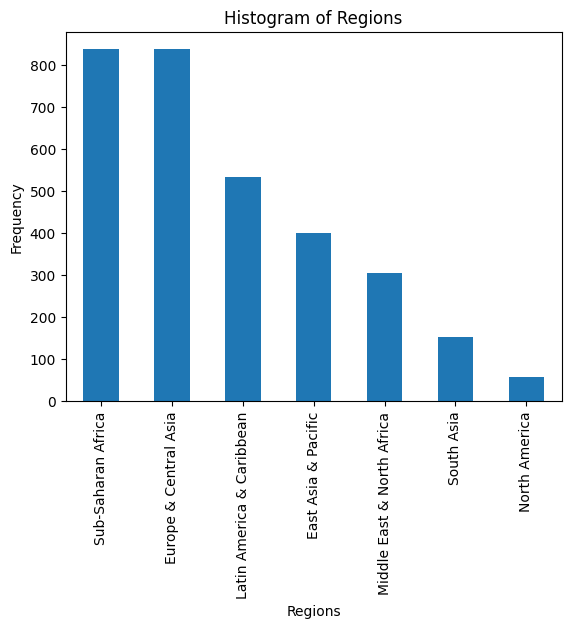

In [8]:
region_counts = data['Region'].value_counts()
region_counts.plot(kind='bar')
plt.xlabel('Regions')
plt.ylabel('Frequency')
plt.title('Histogram of Regions')
plt.show()

In [9]:
unique_values = data['IncomeGroup'].unique()
print(unique_values)

['Low income' 'Lower middle income' 'Upper middle income' 'High income']


### Drop 'Country Code,' 'Country Name,' 'Region,' and 'Corruption' features

In [10]:
columns_to_drop = ['Corruption', 'Country Code', 'Region', 'Country Name', 'Year']
data = data.drop(columns=columns_to_drop)
data = data.dropna()
data = data.rename(columns={"Prevelance of Undernourishment": "Prevalence of Undernourishment"})

### Ensure all nulls have been removed and check number of remaining observations

In [11]:
null_counts = data.isnull().sum()
print(null_counts)

IncomeGroup                       0
Life Expectancy World Bank        0
Prevalence of Undernourishment    0
CO2                               0
Health Expenditure %              0
Education Expenditure %           0
Unemployment                      0
Sanitation                        0
Injuries                          0
Communicable                      0
NonCommunicable                   0
dtype: int64


In [12]:
num_rows = len(data)
print(num_rows)

1296


## Preprocess Data

### View the data type for each feature

In [13]:
print(data.dtypes)

IncomeGroup                        object
Life Expectancy World Bank        float64
Prevalence of Undernourishment    float64
CO2                               float64
Health Expenditure %              float64
Education Expenditure %           float64
Unemployment                      float64
Sanitation                        float64
Injuries                          float64
Communicable                      float64
NonCommunicable                   float64
dtype: object


### Assign "object" data types to the object "categorical_columns"
### Assign "int64" and "float64" data types to the object "continuous_columns"

In [14]:
categorical_columns = ['IncomeGroup']
continuous_columns = ['Prevalence of Undernourishment',
                      'CO2', 'Health Expenditure %', 'Education Expenditure %',
                      'Unemployment', 'Sanitation', 'Injuries', 'Communicable',
                      'NonCommunicable']

### Assign features (X) & target (y), split into train/test sets, and transform using Pipeline

In [15]:
X = data.drop(columns=['Life Expectancy World Bank'])
y = data['Life Expectancy World Bank']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', continuous_transformer, continuous_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

## Explore Data

### Display Correlation Matrix

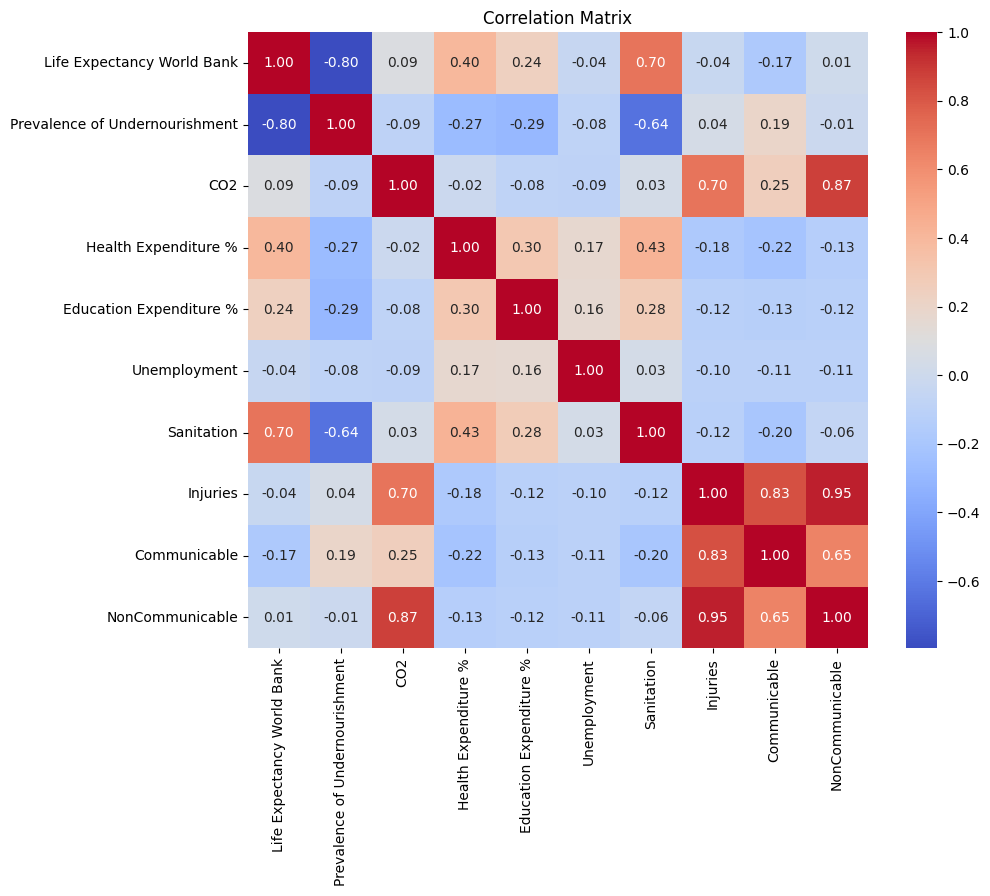

In [16]:
correlation_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Display histograms

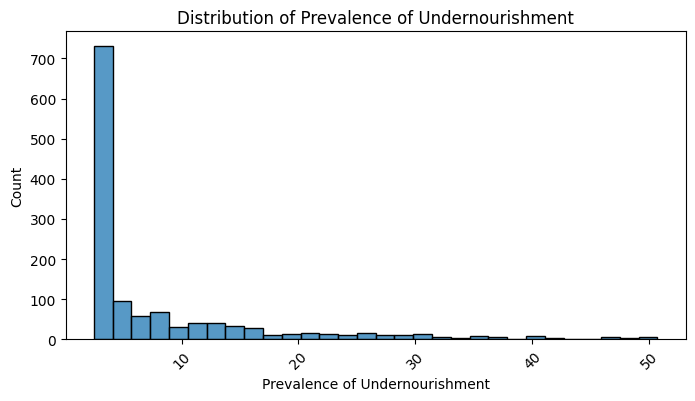

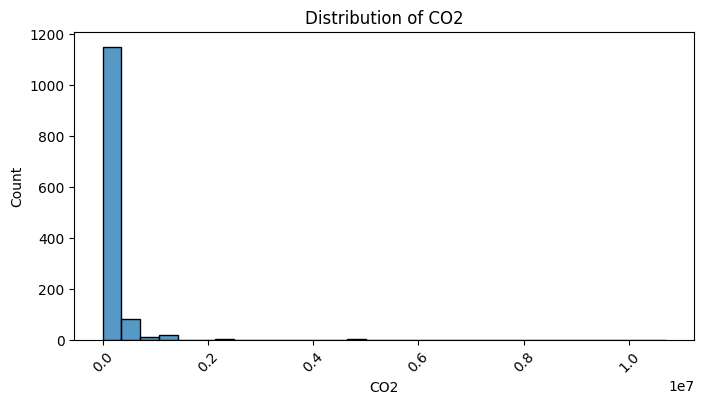

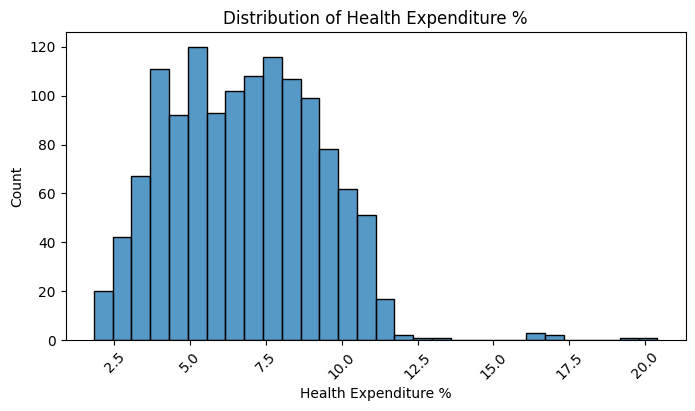

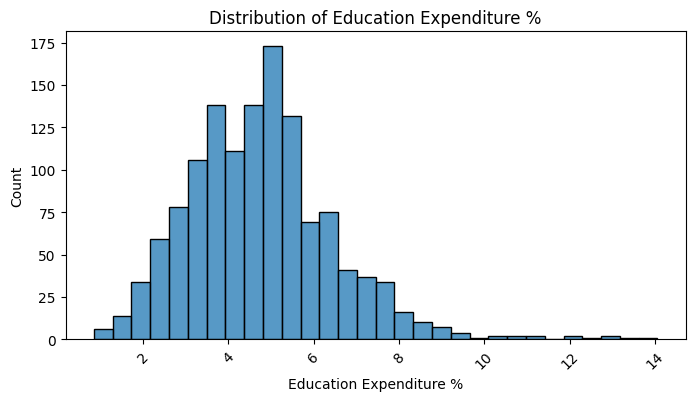

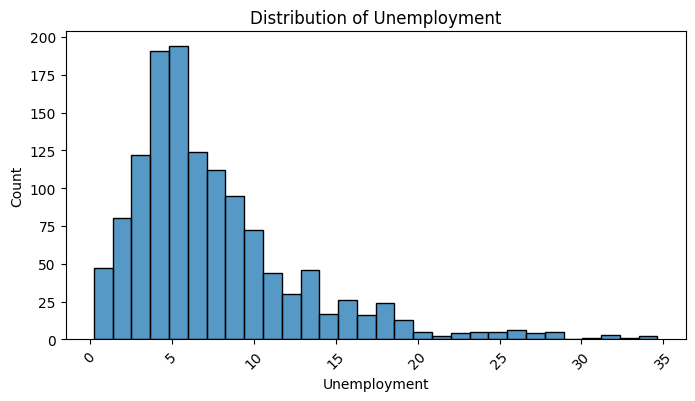

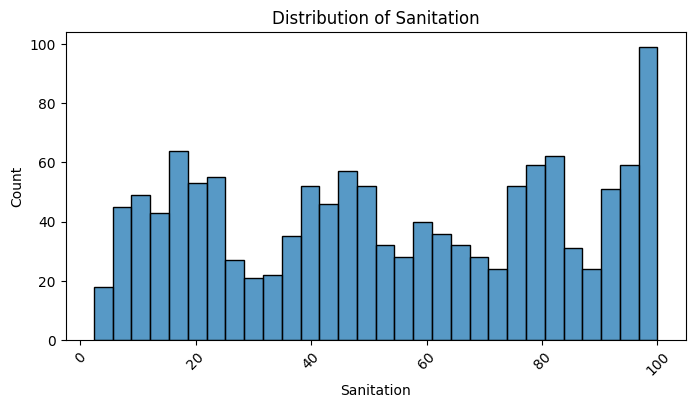

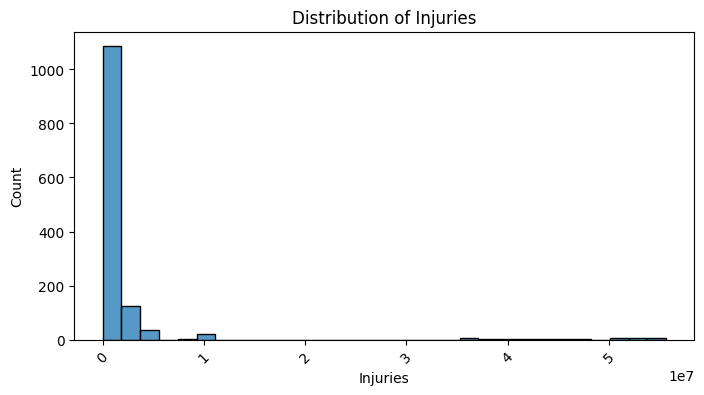

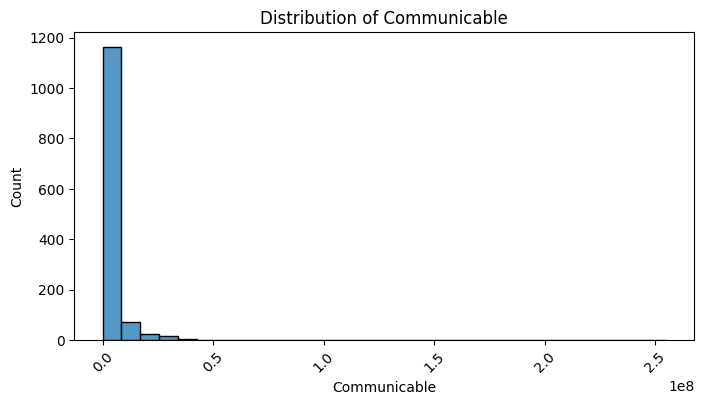

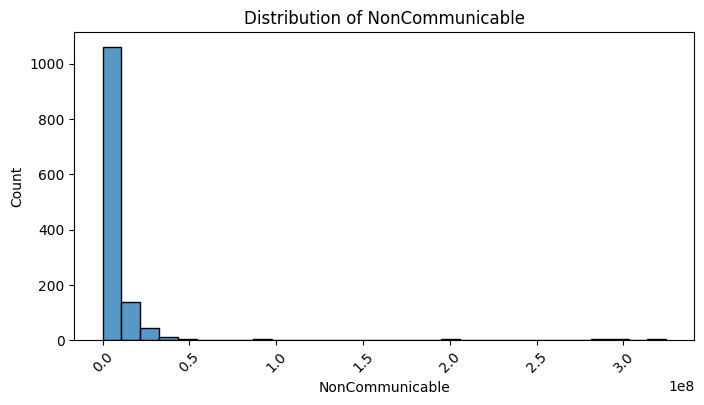

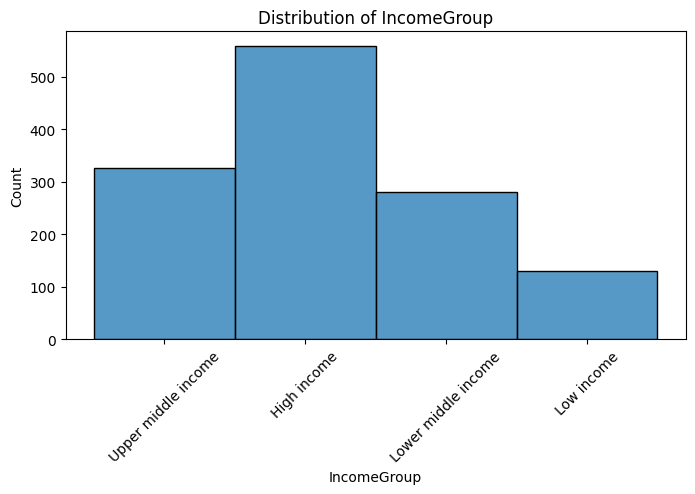

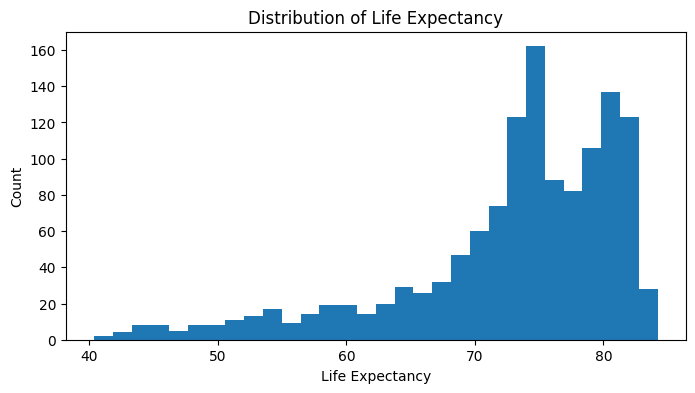

In [17]:
for column in continuous_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=data, x=column, bins=30)
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {column}')
    plt.show()

for column in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=data, x=column, bins=30)
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {column}')
    plt.show()

plt.figure(figsize=(8,4))
plt.hist(data['Life Expectancy World Bank'], bins=30)
plt.xlabel('Life Expectancy')
plt.ylabel('Count')
plt.title('Distribution of Life Expectancy')
plt.show()

## Run Models

### Linear Regression(Lasso)

In [18]:
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train_preprocessed, y_train)
optimal_alpha = lasso_cv.alpha_
print(f"The optimal alpha is: {optimal_alpha}")

The optimal alpha is: 0.007067596725959453


In [19]:
lasso_model = Lasso(alpha=optimal_alpha)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso', lasso_model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Prevalence of '
                                                   'Undernourishment',
                                                   'CO2',
                                                   'Health Expenditure %',
                                                   'Education Expenditure %',
                                                   'Unemployment', 'Sanitation',
                                                   'Injuries', 'Communicable',
                                                   'NonCommunicable']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['IncomeGroup'])])),
                ('lasso', Lasso(alpha=0.007067596725959453))])

In [20]:
y_val_pred = pipeline.predict(X_val)

val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
val_r_squared = r2_score(y_val, y_val_pred)

print(f"Validation MAE: {val_mae}")
print(f"Validation MSE: {val_mse}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation R-squared: {val_r_squared}")

Validation MAE: 3.3141906353640667
Validation MSE: 23.40225002632476
Validation RMSE: 4.837587211237102
Validation R-squared: 0.7283829462643665


In [21]:
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r_squared = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r_squared}")

Mean Absolute Error (MAE): 2.9758843528704193
Mean Squared Error (MSE): 19.153683583580165
Root Mean Squared Error (RMSE): 4.376492155091811
R-squared: 0.7470313922494793


In [22]:
def get_feature_names(column_transformer):
    """Get feature names from a ColumnTransformer"""
    output_features = []

    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(pipe, 'get_feature_names_out'):
                transformed_features = pipe.get_feature_names_out(features)
                output_features.extend(transformed_features)
            else:
                output_features.extend(features)

    return output_features

transformed_feature_names = get_feature_names(pipeline.named_steps['preprocessor'])

coefficients = pipeline.named_steps['lasso'].coef_

feature_importance = pd.DataFrame({
    'Feature': transformed_feature_names,
    'Coefficient': coefficients
})

feature_importance['abs_coefficient'] = feature_importance['Coefficient'].abs()
significant_features = feature_importance.sort_values(by='abs_coefficient', ascending=False)

print(significant_features)

                            Feature  Coefficient  abs_coefficient
10           IncomeGroup_Low income    -9.058073         9.058073
9           IncomeGroup_High income     4.461058         4.461058
0    Prevalence of Undernourishment    -3.274279         3.274279
12  IncomeGroup_Upper middle income     2.579931         2.579931
8                   NonCommunicable     1.314407         1.314407
2              Health Expenditure %     1.245856         1.245856
4                      Unemployment    -0.856902         0.856902
6                          Injuries    -0.711186         0.711186
11  IncomeGroup_Lower middle income    -0.703585         0.703585
1                               CO2    -0.606443         0.606443
5                        Sanitation     0.589383         0.589383
3           Education Expenditure %    -0.075664         0.075664
7                      Communicable    -0.069045         0.069045


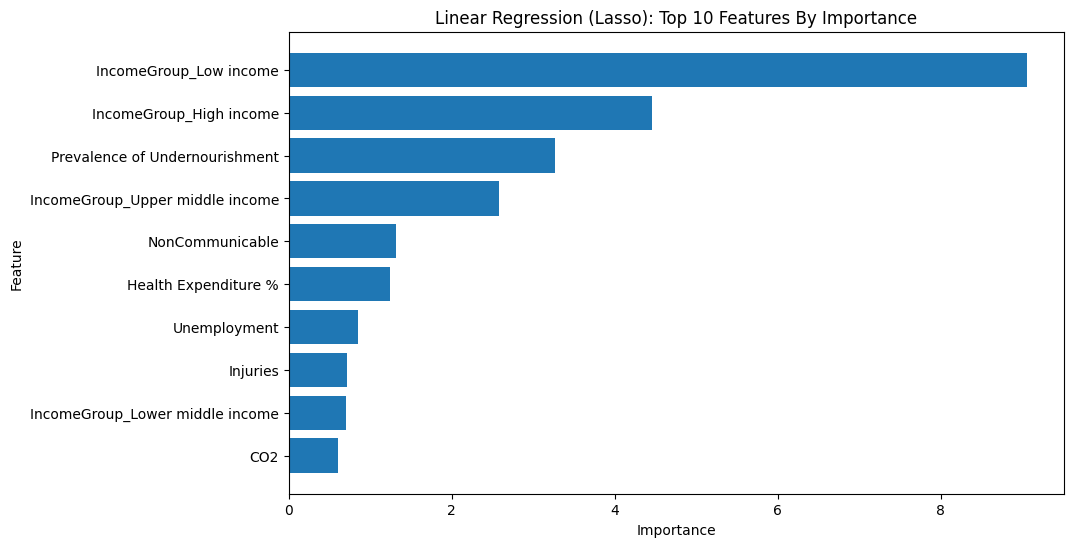

In [23]:
coefficients = pipeline.named_steps['lasso'].coef_
transformed_feature_names = get_feature_names(pipeline.named_steps['preprocessor'])

feature_importance = pd.DataFrame({
    'Feature': transformed_feature_names,
    'Coefficient': coefficients
})

feature_importance['abs_coefficient'] = feature_importance['Coefficient'].abs()

top_10_features = feature_importance.sort_values(by='abs_coefficient', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['abs_coefficient'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Linear Regression (Lasso): Top 10 Features By Importance')
plt.gca().invert_yaxis()
plt.show()

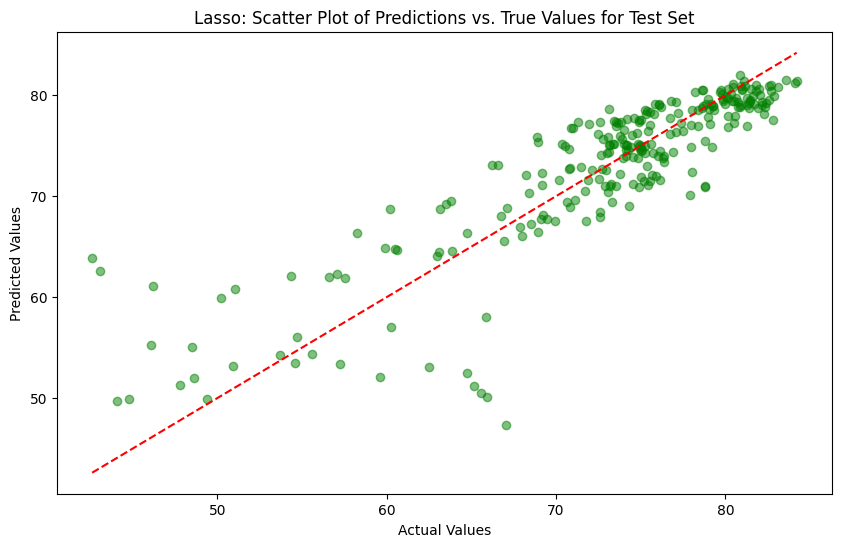

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line for perfect predictions
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Lasso: Scatter Plot of Predictions vs. True Values for Test Set')
plt.show()

### Linear Regression (Ridge)

In [25]:
ridge_cv = RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10, 100], cv=5)
ridge_cv.fit(X_train_preprocessed, y_train)

optimal_alpha = ridge_cv.alpha_
print(f"The optimal alpha is: {optimal_alpha}")

The optimal alpha is: 0.1


In [26]:
ridge_model = Ridge(alpha=optimal_alpha)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('ridge', ridge_model)
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Prevalence of '
                                                   'Undernourishment',
                                                   'CO2',
                                                   'Health Expenditure %',
                                                   'Education Expenditure %',
                                                   'Unemployment', 'Sanitation',
                                                   'Injuries', 'Communicable',
                                                   'NonCommunicable']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['IncomeGroup'])])),
                ('ridge', Ridge(alpha=0.1))])

In [27]:
y_val_pred = pipeline.predict(X_val)

val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
val_r_squared = r2_score(y_val, y_val_pred)

print(f"Validation MAE: {val_mae}")
print(f"Validation MSE: {val_mse}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation R-squared: {val_r_squared}")

Validation MAE: 3.316405984365597
Validation MSE: 23.346132939395943
Validation RMSE: 4.8317836188509045
Validation R-squared: 0.7290342664493352


In [28]:
y_pred = pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r_squared = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared: {r_squared}")

Mean Absolute Error (MAE): 2.976453621704197
Mean Squared Error (MSE): 19.088311020136384
Root Mean Squared Error (RMSE): 4.369017168670362
R-squared: 0.7478947878614666


In [29]:
def get_feature_names(column_transformer):
    """Get feature names from a ColumnTransformer"""
    output_features = []

    for name, pipe, features in column_transformer.transformers_:
        if name != 'remainder':
            if hasattr(pipe, 'get_feature_names_out'):
                transformed_features = pipe.get_feature_names_out(features)
                output_features.extend(transformed_features)
            else:
                output_features.extend(features)

    return output_features

transformed_feature_names = get_feature_names(pipeline.named_steps['preprocessor'])

coefficients = pipeline.named_steps['ridge'].coef_

feature_importance = pd.DataFrame({
    'Feature': transformed_feature_names,
    'Coefficient': coefficients
})

feature_importance['abs_coefficient'] = feature_importance['Coefficient'].abs()
significant_features = feature_importance.sort_values(by='abs_coefficient', ascending=False)

print(significant_features)

                            Feature  Coefficient  abs_coefficient
10           IncomeGroup_Low income    -8.626205         8.626205
9           IncomeGroup_High income     5.322786         5.322786
8                   NonCommunicable     3.440709         3.440709
12  IncomeGroup_Upper middle income     3.411246         3.411246
0    Prevalence of Undernourishment    -3.238133         3.238133
6                          Injuries    -2.638752         2.638752
2              Health Expenditure %     1.273330         1.273330
1                               CO2    -1.240474         1.240474
4                      Unemployment    -0.869102         0.869102
5                        Sanitation     0.499627         0.499627
7                      Communicable     0.260576         0.260576
11  IncomeGroup_Lower middle income    -0.107826         0.107826
3           Education Expenditure %    -0.063279         0.063279


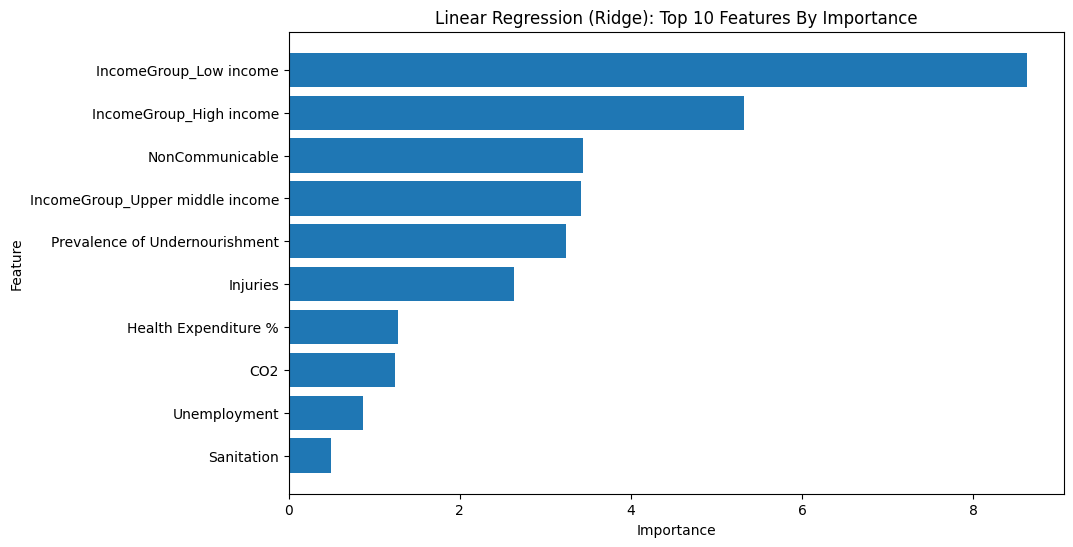

In [30]:
coefficients = pipeline.named_steps['ridge'].coef_
transformed_feature_names = get_feature_names(pipeline.named_steps['preprocessor'])

feature_importance = pd.DataFrame({
    'Feature': transformed_feature_names,
    'Coefficient': coefficients
})

feature_importance['abs_coefficient'] = feature_importance['Coefficient'].abs()

top_10_features = feature_importance.sort_values(by='abs_coefficient', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['abs_coefficient'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Linear Regression (Ridge): Top 10 Features By Importance')
plt.gca().invert_yaxis()
plt.show()

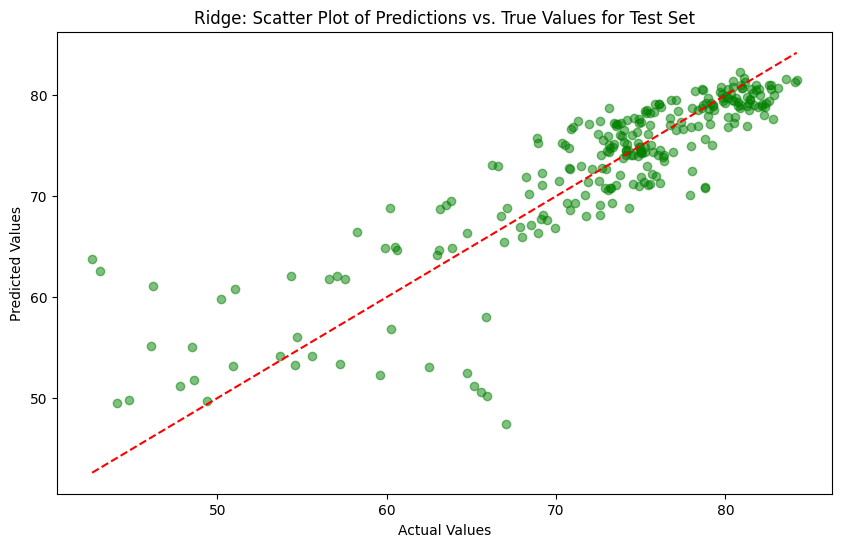

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line for perfect predictions
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Ridge: Scatter Plot of Predictions vs. True Values for Test Set')
plt.show()

### KNN Regressor

In [32]:
param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'p': [1, 2]
}

knn_regressor = KNeighborsRegressor()

grid_search = GridSearchCV(knn_regressor, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train_preprocessed, y_train)

best_params = grid_search.best_params_
best_knn_model = grid_search.best_estimator_

print(f"Best parameters: {best_params}")

Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


In [33]:
y_val_pred = best_knn_model.predict(X_val_preprocessed)

val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
val_r_squared = r2_score(y_val, y_val_pred)

print(f"Validation MAE: {val_mae}")
print(f"Validation MSE: {val_mse}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation R-squared: {val_r_squared}")

Validation MAE: 0.8323720473424197
Validation MSE: 2.9760464371976787
Validation RMSE: 1.7251221513845558
Validation R-squared: 0.965458664694943


In [34]:
y_pred = best_knn_model.predict(X_test_preprocessed)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R²): {r_squared}")

Mean Squared Error (MSE): 4.2090566188816085
Root Mean Squared Error (RMSE): 2.0515985520763094
Mean Absolute Error (MAE): 0.9493277099695805
R-squared (R²): 0.9444096907952276


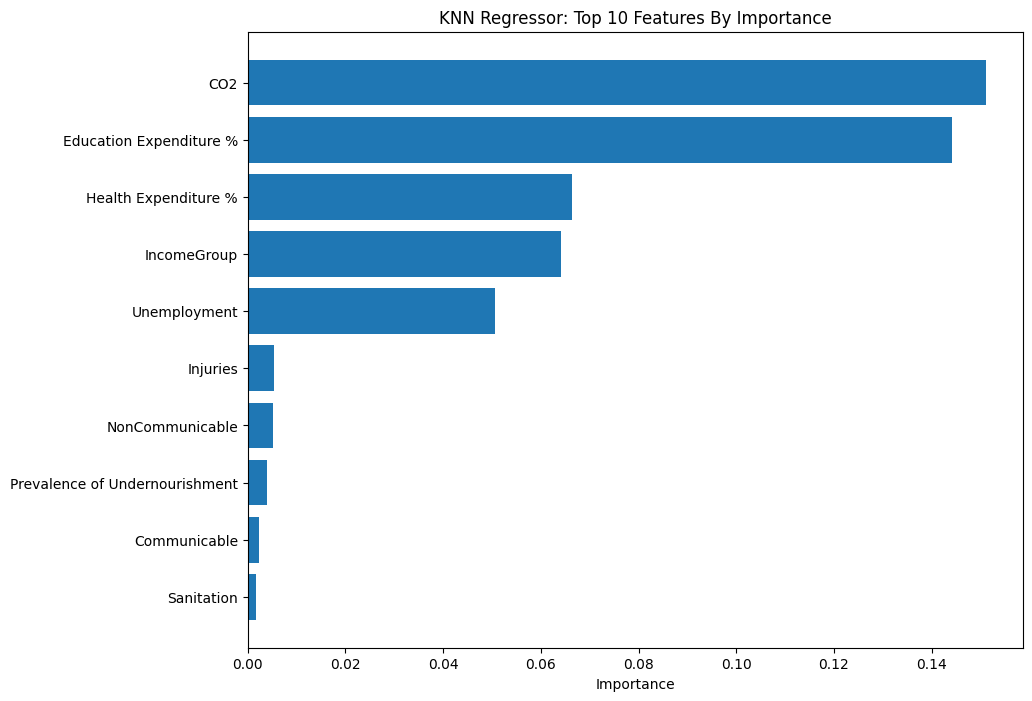

In [35]:
result = permutation_importance(best_knn_model, X_test_preprocessed, y_test, n_repeats=30, random_state=42)
feature_importances = result.importances_mean

features = X.columns
feature_importance_dict = dict(zip(features, feature_importances))

sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

top_10_features = sorted_features[:10]
feature_names, importances = zip(*top_10_features)


plt.figure(figsize=(10, 8))
plt.barh(feature_names, importances)
plt.xlabel('Importance')
plt.title('KNN Regressor: Top 10 Features By Importance')
plt.gca().invert_yaxis()
plt.show()

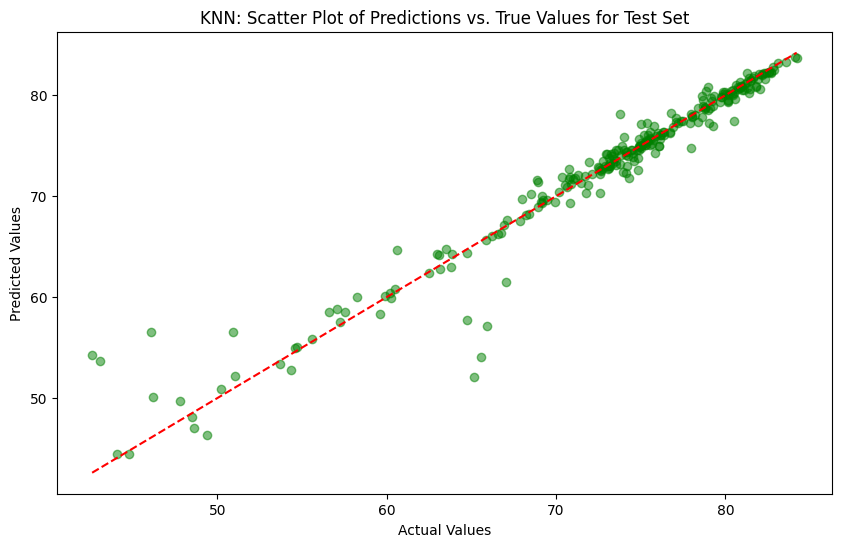

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line for perfect predictions
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('KNN: Scatter Plot of Predictions vs. True Values for Test Set')
plt.show()

### Decision Tree

In [37]:
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'random_state': [42]
}

decision_tree = DecisionTreeRegressor()

grid_search = GridSearchCV(decision_tree, param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train_preprocessed, y_train)

best_params = grid_search.best_params_
best_tree_model = grid_search.best_estimator_

print(f"Best parameters: {best_params}")

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_tree_model)
])

X_test_preprocessed = preprocessor.transform(X_test)

Best parameters: {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 42}


In [38]:
y_val_pred = best_tree_model.predict(X_val_preprocessed)

val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = mean_squared_error(y_val, y_val_pred, squared=False)
val_r_squared = r2_score(y_val, y_val_pred)

print(f"Validation MAE: {val_mae}")
print(f"Validation MSE: {val_mse}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation R-squared: {val_r_squared}")

Validation MAE: 0.9869210834896814
Validation MSE: 2.8924779057251873
Validation RMSE: 1.7007286396498376
Validation R-squared: 0.9664285987088963


In [39]:
y_pred = best_tree_model.predict(X_test_preprocessed)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r_squared}")

Mean Squared Error: 2.859691277954969
Root Mean Squared Error: 1.6910621744793919
Mean Absolute Error: 0.9216014071294552
R-squared: 0.9622311751144969


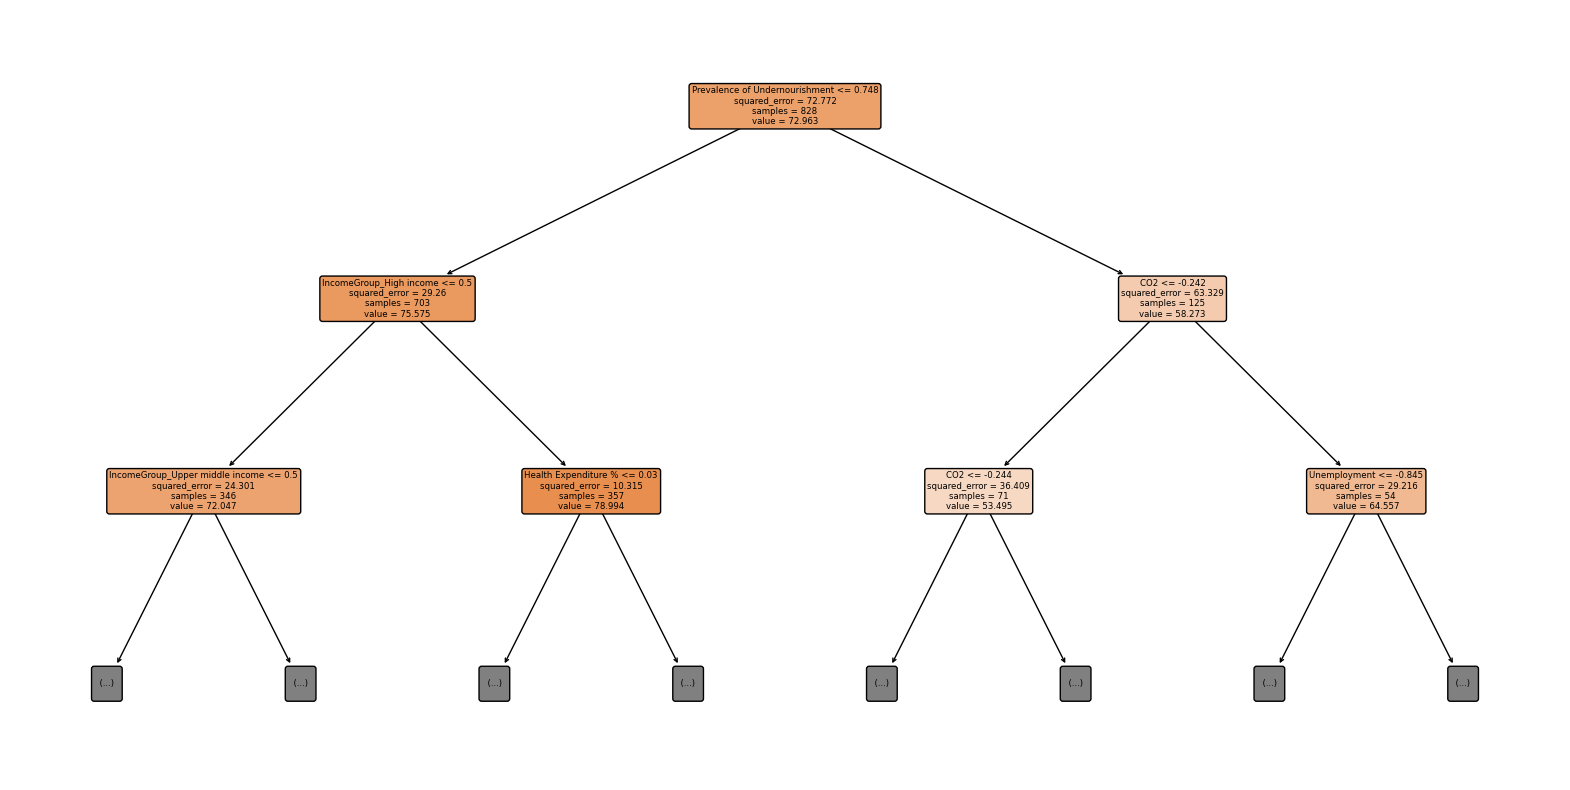

In [40]:
feature_names = continuous_columns.copy()

categories = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_columns)
feature_names.extend(categories)

plt.figure(figsize=(20, 10))
plot_tree(best_tree_model,
          feature_names=feature_names,
          filled=True,
          rounded=True,
          max_depth=2)
plt.show()

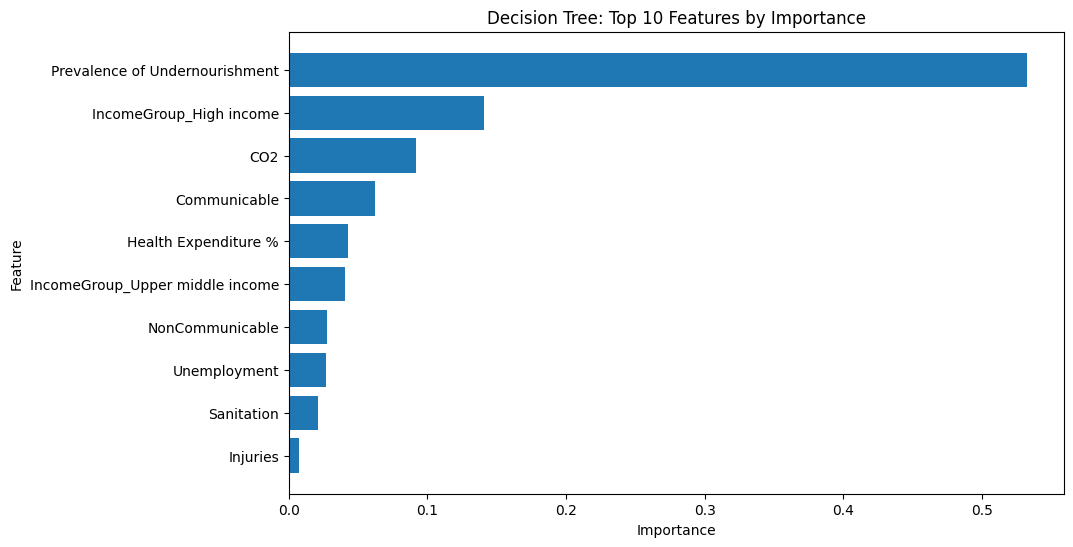

In [41]:
feature_importances = best_tree_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names,'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_10_features = feature_importance_df.head(10)

plt.figure(figsize=(10, 6))

for i, (imp, feature) in enumerate(zip(top_10_features['Importance'], top_10_features['Feature'])):
    plt.barh(feature, imp, color='C0')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Decision Tree: Top 10 Features by Importance')
plt.gca().invert_yaxis()
plt.show()

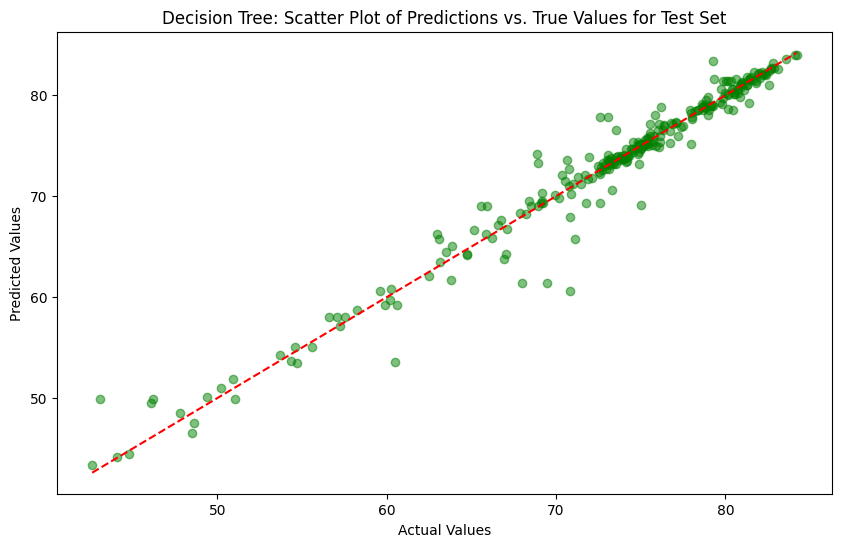

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line for perfect predictions
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Decision Tree: Scatter Plot of Predictions vs. True Values for Test Set')
plt.show()

### Random Forest *Best Model*

In [44]:
param_grid = {
    'n_estimators': [50],
    'max_depth': [10, 20],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'max_features': ['auto', 3, 5, 7],
    'bootstrap': [True, False]
}

random_forest = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='neg_mean_squared_error')

best_mse = np.inf
best_estimator = None
no_improvement_rounds = 0
max_no_improvement_rounds = 10

for _ in range(max_no_improvement_rounds):
    grid_search.fit(X_train_preprocessed, y_train)

    best_forest_model = grid_search.best_estimator_
    y_val_pred = best_forest_model.predict(X_val_preprocessed)
    mse_val = mean_squared_error(y_val, y_val_pred)

    if mse_val < best_mse:
        best_mse = mse_val
        best_estimator = best_forest_model
        no_improvement_rounds = 0
    else:
        no_improvement_rounds += 1

    if no_improvement_rounds >= max_no_improvement_rounds:
        break

best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', best_forest_model)
])

Best parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [45]:
y_val_pred = best_forest_model.predict(X_val_preprocessed)

mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
mae_val = mean_absolute_error(y_val, y_val_pred)
r_squared_val = r2_score(y_val, y_val_pred)

print(f"Validation Mean Squared Error: {mse_val}")
print(f"Validation Root Mean Squared Error: {rmse_val}")
print(f"Validation Mean Absolute Error: {mae_val}")
print(f"Validation R-squared: {r_squared_val}")

Validation Mean Squared Error: 1.6539219031687176
Validation Root Mean Squared Error: 1.2860489505336559
Validation Mean Absolute Error: 0.6349752440507542
Validation R-squared: 0.9808038374967285


In [46]:
y_pred = best_forest_model.predict(X_test_preprocessed)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r_squared}")

Mean Squared Error: 1.3559132550064807
Root Mean Squared Error: 1.1644368832214482
Mean Absolute Error: 0.6392295442353122
R-squared: 0.982092035359532


In [47]:
low_value_threshold = 50

# Creating a subset of the test set with low values
low_values_subset = X_test[y_test < low_value_threshold]

# Checking if the low values subset is not empty before proceeding
if not low_values_subset.empty:
    actual_low_values = y_test[y_test < low_value_threshold]

    # Making predictions on the low values subset using the best_forest_model
    predicted_low_values = best_forest_model.predict(preprocessor.transform(low_values_subset))

    # Evaluating the model performance on low values
    mae_low_values = mean_absolute_error(actual_low_values, predicted_low_values)
    mse_low_values = mean_squared_error(actual_low_values, predicted_low_values)
    rmse_low_values = mean_squared_error(actual_low_values, predicted_low_values, squared=False)
    r_squared_low_values = r2_score(actual_low_values, predicted_low_values)

    print(f"Mean Absolute Error (MAE) on Low Values: {mae_low_values}")
    print(f"Mean Squared Error (MSE) on Low Values: {mse_low_values}")
    print(f"Root Mean Squared Error (RMSE) on Low Values: {rmse_low_values}")
    print(f"R-squared on Low Values: {r_squared_low_values}")
else:
    print("Low values subset is empty.")


Mean Absolute Error (MAE) on Low Values: 2.9787199999999983
Mean Squared Error (MSE) on Low Values: 15.863860183680023
Root Mean Squared Error (RMSE) on Low Values: 3.982946168815243
R-squared on Low Values: -1.9938498685196917


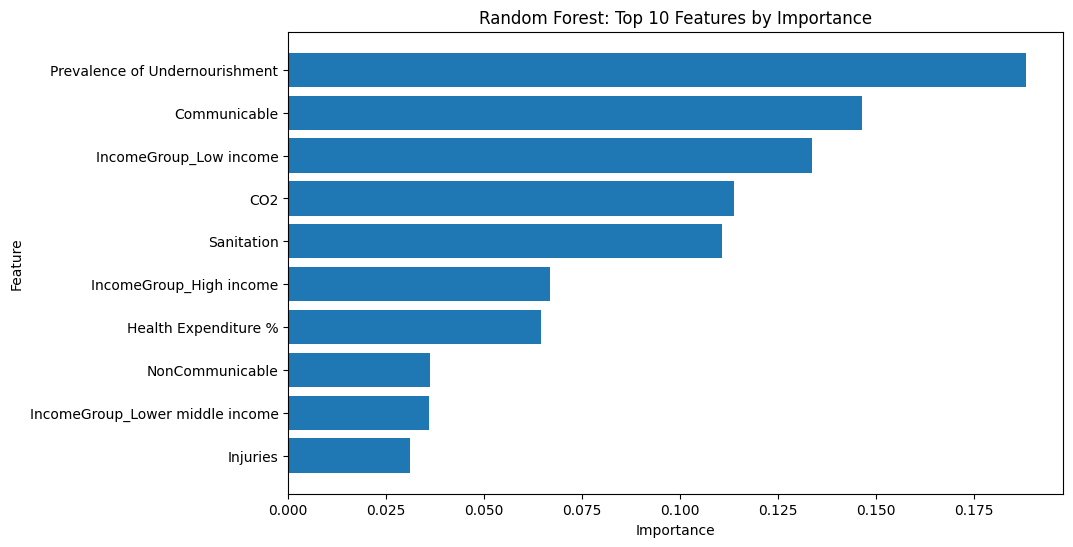

In [48]:
feature_importances = best_forest_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_names,'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
top_10_features = feature_importance_df.head(10)

plt.figure(figsize=(10, 6))

for i, (imp, feature) in enumerate(zip(top_10_features['Importance'], top_10_features['Feature'])):
    plt.barh(feature, imp, color='C0')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest: Top 10 Features by Importance')
plt.gca().invert_yaxis()
plt.show()

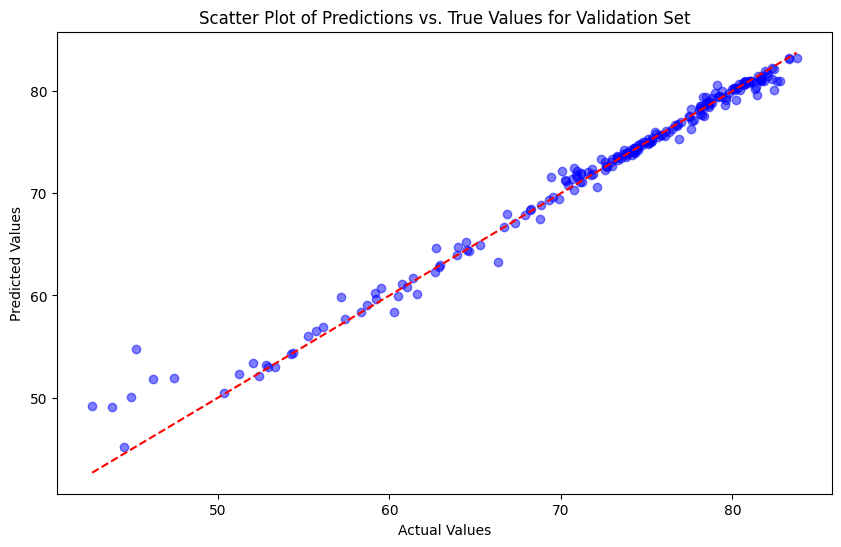

In [49]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5, color='blue')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')  # Line for perfect predictions
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predictions vs. True Values for Validation Set')
plt.show()

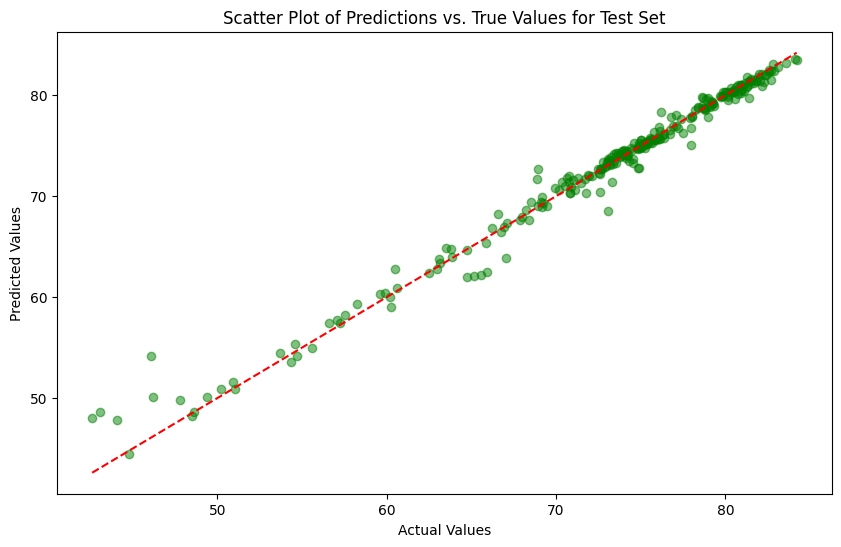

In [50]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Line for perfect predictions
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predictions vs. True Values for Test Set')
plt.show()

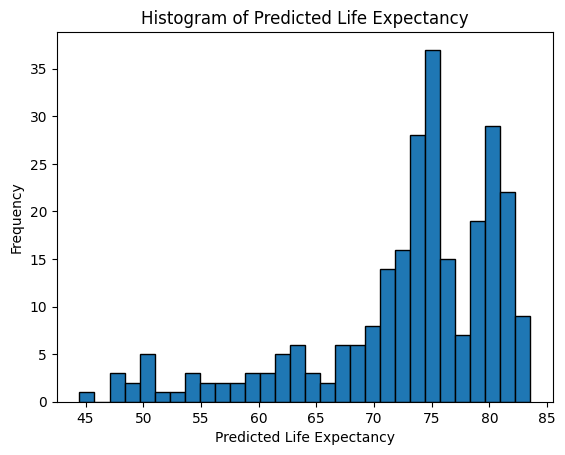

In [51]:
plt.hist(y_pred, bins=30, edgecolor='black')
plt.xlabel('Predicted Life Expectancy')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Life Expectancy')
plt.show()


In [52]:
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
actual_quantiles = np.percentile(y_test, np.array(quantiles) * 100)
predicted_quantiles = np.percentile(y_pred, np.array(quantiles) * 100)

quantile_df = pd.DataFrame({
    'Quantile': quantiles,
    'Actual Value': actual_quantiles,
    'Predicted Value': predicted_quantiles
})

print(quantile_df)


   Quantile  Actual Value  Predicted Value
0      0.10     60.219600        60.400860
1      0.25     70.604000        70.594101
2      0.50     74.881000        74.747805
3      0.75     79.047018        79.268886
4      0.90     81.399512        81.142389


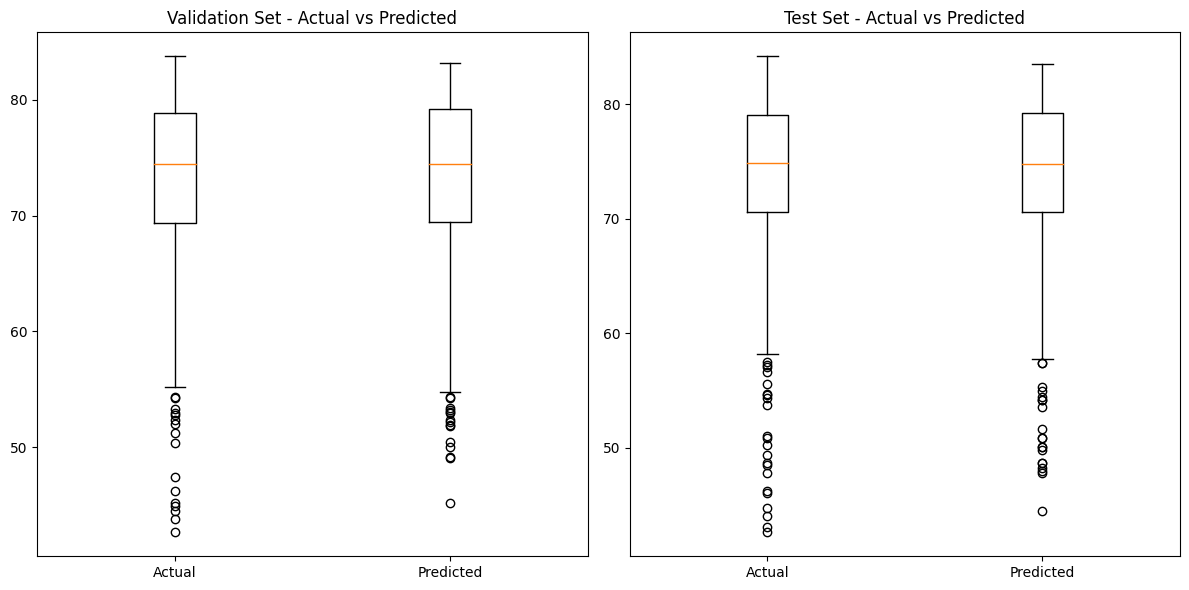

In [53]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.boxplot([y_val, y_val_pred], labels=['Actual', 'Predicted'])
plt.title('Validation Set - Actual vs Predicted')

plt.subplot(1, 2, 2)
plt.boxplot([y_test, y_pred], labels=['Actual', 'Predicted'])
plt.title('Test Set - Actual vs Predicted')

plt.tight_layout()
plt.show()

## Most Significant Variables

### Countries

In [54]:
df = pd.read_csv('life expectancy.csv')
df = df.rename(columns={"Prevelance of Undernourishment": "Prevalence of Undernourishment"})

top_undernourishment = df.groupby('Country Name')['Prevalence of Undernourishment'].max().sort_values(ascending=False).head(5)

top_sanitation = df.groupby('Country Name')['Sanitation'].min().sort_values(ascending=True).head(5)

low_income_countries = df[df['IncomeGroup'] == 'Low income']['Country Name'].unique()

top_communicable = df.groupby('Country Name')['Communicable'].max().sort_values(ascending=False).head(5)

top_co2 = df.groupby('Country Name')['CO2'].max().sort_values(ascending=False).head(5)

top_undernourishment_list = top_undernourishment.index.tolist()
top_sanitation_list = top_sanitation.index.tolist()
low_income_countries_list = low_income_countries.tolist()
top_communicable_list = top_communicable.index.tolist()
top_co2_list = top_co2.index.tolist()

print("Top 5 Countries by Prevalence of Undernourishment:")
print(top_undernourishment_list)

print("\nTop 5 Countries by Sanitation:")
print(top_sanitation_list)

print("\nLow Income Countries:")
print(low_income_countries_list)

print("\nTop 5 Countries by Communicable Diseases:")
print(top_communicable_list)

print("\nTop 5 Countries by CO2 Emissions:")
print(top_co2_list)

Top 5 Countries by Prevalence of Undernourishment:
['Somalia', 'Angola', 'Haiti', 'Sierra Leone', 'Central African Republic']

Top 5 Countries by Sanitation:
['Ethiopia', 'Guinea-Bissau', 'Madagascar', 'Ghana', 'Tuvalu']

Low Income Countries:
['Afghanistan', 'Burundi', 'Burkina Faso', 'Central African Republic', 'Eritrea', 'Ethiopia', 'Guinea', 'Guinea-Bissau', 'Liberia', 'Madagascar', 'Mali', 'Mozambique', 'Malawi', 'Niger', 'Rwanda', 'Sudan', 'Sierra Leone', 'Somalia', 'South Sudan', 'Chad', 'Togo', 'Uganda', 'Zambia']

Top 5 Countries by Communicable Diseases:
['India', 'Nigeria', 'Pakistan', 'China', 'Ethiopia']

Top 5 Countries by CO2 Emissions:
['China', 'United States', 'India', 'Japan', 'Germany']


In [55]:
low_income_countries = df[df['IncomeGroup'] == 'Low income']

max_undernourishment = low_income_countries.groupby('Country Name')['Prevalence of Undernourishment'].max()
min_sanitation = low_income_countries.groupby('Country Name')['Sanitation'].min()
max_communicable = low_income_countries.groupby('Country Name')['Communicable'].max()
max_co2 = low_income_countries.groupby('Country Name')['CO2'].max()

combined_df = pd.DataFrame({
    'Max_Undernourishment': max_undernourishment,
    'Min_Sanitation': min_sanitation,
    'Max_Communicable': max_communicable,
    'Max_CO2': max_co2
})

weights = {
    'Max_Undernourishment': 1,
    'Min_Sanitation': 1,
    'Max_Communicable': 1,
    'Max_CO2': 1
}

combined_df['Combined_Score'] = (combined_df * pd.Series(weights)).sum(axis=1)

top_low_income_countries = combined_df.sort_values(by='Combined_Score', ascending=False).head(5)

top_low_income_countries_list = top_low_income_countries.index.tolist()

print("Top 5 Low-Income Countries with the Highest Combined Score:")
print(top_low_income_countries_list)

Top 5 Low-Income Countries with the Highest Combined Score:
['Ethiopia', 'Uganda', 'Mozambique', 'Niger', 'Malawi']


### Regions

In [56]:
top_undernourishment = df.groupby('Region')['Prevalence of Undernourishment'].max().sort_values(ascending=False).head(5)

top_sanitation = df.groupby('Region')['Sanitation'].min().sort_values(ascending=True).head(5)

low_income_regions = df[df['IncomeGroup'] == 'Low income']['Region'].unique()

top_communicable = df.groupby('Region')['Communicable'].max().sort_values(ascending=False).head(5)

top_co2 = df.groupby('Region')['CO2'].max().sort_values(ascending=False).head(5)

top_undernourishment_list = top_undernourishment.index.tolist()
top_sanitation_list = top_sanitation.index.tolist()
low_income_regions_list = low_income_regions.tolist()
top_communicable_list = top_communicable.index.tolist()
top_co2_list = top_co2.index.tolist()

print("Top 5 Region by Prevalence of Undernourishment:")
print(top_undernourishment_list)

print("\nTop 5 Region by Sanitation:")
print(top_sanitation_list)

print("\nLow Income Regions:")
print(low_income_regions_list)

print("\nTop 5 Regions by Communicable Diseases:")
print(top_communicable_list)

print("\nTop 5 Regions by CO2 Emissions:")
print(top_co2_list)

Top 5 Region by Prevalence of Undernourishment:
['Sub-Saharan Africa', 'Latin America & Caribbean', 'South Asia', 'Middle East & North Africa', 'East Asia & Pacific']

Top 5 Region by Sanitation:
['Sub-Saharan Africa', 'East Asia & Pacific', 'South Asia', 'Middle East & North Africa', 'Europe & Central Asia']

Low Income Regions:
['South Asia', 'Sub-Saharan Africa']

Top 5 Regions by Communicable Diseases:
['South Asia', 'Sub-Saharan Africa', 'East Asia & Pacific', 'Latin America & Caribbean', 'North America']

Top 5 Regions by CO2 Emissions:
['East Asia & Pacific', 'North America', 'South Asia', 'Europe & Central Asia', 'Middle East & North Africa']


In [57]:
max_undernourishment = df.groupby('Region')['Prevalence of Undernourishment'].max()
min_sanitation = df.groupby('Region')['Sanitation'].min()
max_communicable = df.groupby('Region')['Communicable'].max()
max_co2 = df.groupby('Region')['CO2'].max()

combined_df = pd.DataFrame({
    'Max_Undernourishment': max_undernourishment,
    'Min_Sanitation': min_sanitation,
    'Max_Communicable': max_communicable,
    'Max_CO2': max_co2
})

weights = {
    'Max_Undernourishment': 1,
    'Min_Sanitation': 1,
    'Max_Communicable': 1,
    'Max_CO2': 1
}

combined_df['Combined_Score'] = (combined_df * pd.Series(weights)).sum(axis=1)

ranked_regions = combined_df.sort_values(by='Combined_Score', ascending=False)

print("Ranked Regions by Combined Score:")
print(ranked_regions)

Ranked Regions by Combined Score:
                            Max_Undernourishment  Min_Sanitation  \
Region                                                             
South Asia                                  47.8        7.847825   
Sub-Saharan Africa                          70.9        2.377647   
East Asia & Pacific                         37.6        4.741817   
Latin America & Caribbean                   53.7       12.334957   
North America                                2.5       77.575810   
Middle East & North Africa                  42.0        9.425466   
Europe & Central Asia                       26.1       12.184404   

                            Max_Communicable       Max_CO2  Combined_Score  
Region                                                                      
South Asia                      2.685646e+08  2.456300e+06    2.710210e+08  
Sub-Saharan Africa              1.037854e+08  4.479300e+05    1.042334e+08  
East Asia & Pacific             5.002578e+07 

### Years

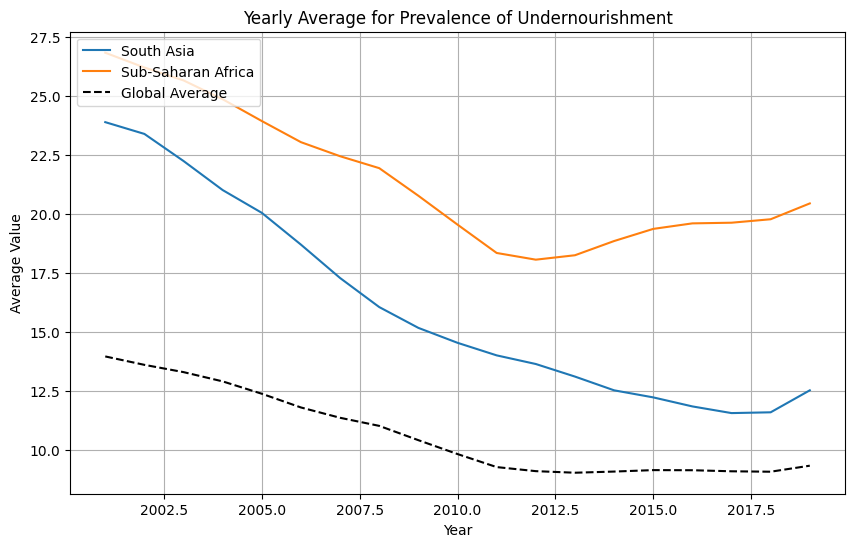

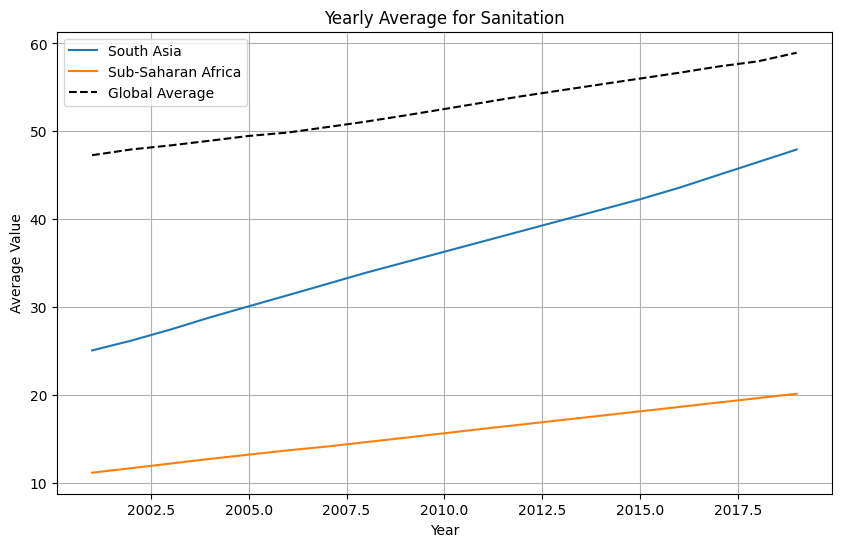

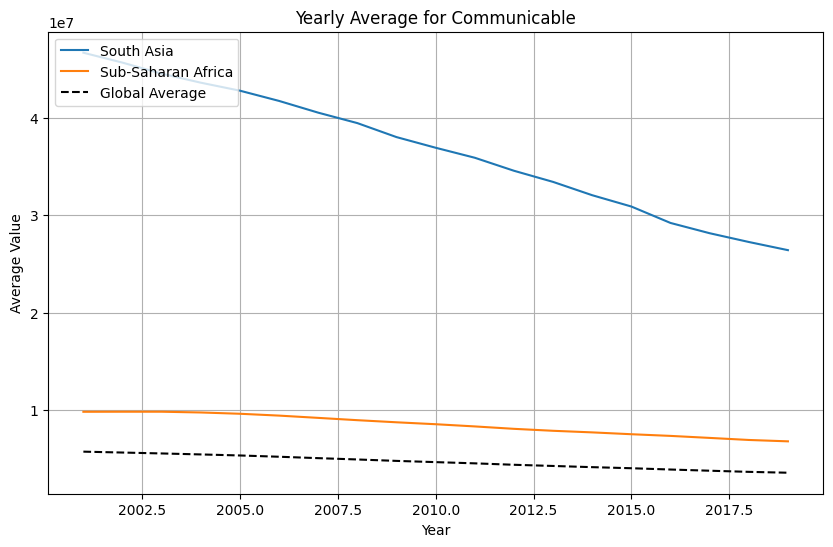

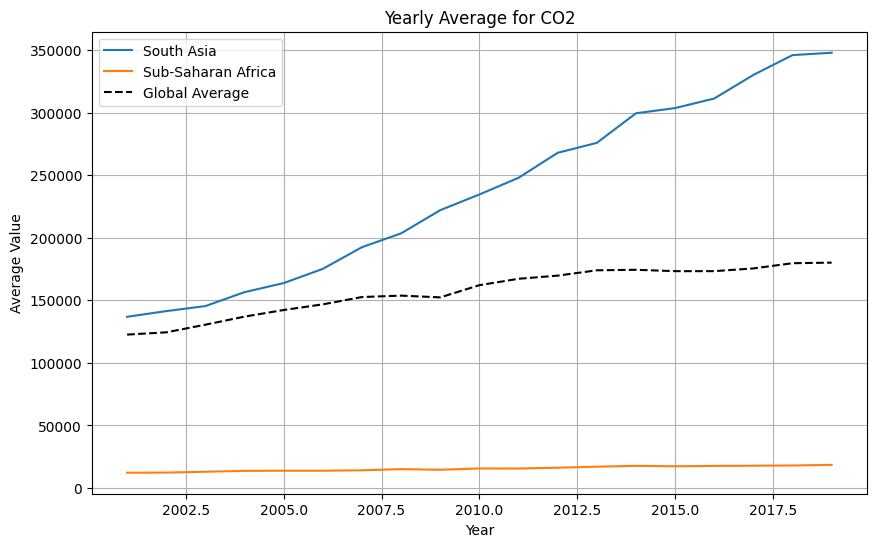

In [59]:
regions_to_plot = ["South Asia", "Sub-Saharan Africa"]

min_year, max_year = df['Year'].min(), df['Year'].max()
all_years = pd.Series(range(int(min_year), int(max_year) + 1))
df_full = pd.DataFrame()

for region in regions_to_plot:
    region_df = df[df['Region'] == region]
    region_df = region_df.groupby('Year').mean().reset_index()
    region_df = region_df.set_index('Year').reindex(all_years).fillna(method='ffill').reset_index()
    region_df['Region'] = region
    df_full = pd.concat([df_full, region_df])

for column in ['Prevalence of Undernourishment', 'Sanitation', 'Communicable', 'CO2']:
    plt.figure(figsize=(10, 6))

    for region in regions_to_plot:
        region_data = df_full[df_full['Region'] == region]
        plt.plot(region_data['index'], region_data[column], label=region)

    global_data = df.groupby('Year')[column].mean()
    plt.plot(global_data.index, global_data, label='Global Average', linestyle='--', color='black')

    plt.title(f'Yearly Average for {column}')
    plt.xlabel('Year')
    plt.ylabel('Average Value')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()
